In [1]:
%matplotlib inline

# **Seminar. Analysis of organoid dynamics in microscopic imaging.**

The purpose of this seminar is that the student familiarizes with fluorescence microscopic imaging analysis through a real application. In particular, you will make use of the concepts learned through the course: segmentation, feature extraction and clustering, to analyze the death dynamics of organoids in fluorescence microscopic images of a coculture of PDOs (Patient Derived Organoids) and T cells. 

By following this notebook the student will learn how to:

**1.**  Test different segmentation methods on 2D images of organoids and evaluate their performance qualitatively. 

**2.**  Extract distinctive features to describe the aspect of the organoids and their context.  
  
**3.**  Build and optimize a classifier that uses the previous features to classify (by clustering) the organoids according to their state (dead or alive).

**4.**  Apply the trained classifier to a set of different videos and obtain the death dynamics curves for organoids. 

**5.**  **Optional part.** You can use the acquired knowledge to perform additional tasks:
* Improving the clustering by designing additional features, e.g., other statistics over the death channel, calculating the percentage of the organoid that is dead (first thresholding the death channel and computing its overlap with each organoid), measuring the ratio between the organoid and death channel...
* Segmenting the T cells and computing, for each organoid, how many are interacting with them (through a distance threshold). 
* Applying the same pipeline to classify the T cells according to their engagement to organoids (dead-scanner-engager).

---

References:
- [1] Waldman, A.D., Fritz, J.M. & Lenardo, M.J. A guide to cancer immunotherapy: from T cell basic science to clinical practice. Nat Rev Immunol 20, 651?668 (2020). https://doi.org/10.1038/s41577-020-0306-5.
- [2] El-Sayes N, Vito A, Mossman K. Tumor Heterogeneity: A Great Barrier in the Age of Cancer Immunotherapy. Cancers (Basel). 2021 Feb 15;13(4):806. doi: 10.3390/cancers13040806.
- [3] Dekkers, J.F., Alieva, M., Cleven, A. et al. Uncovering the mode of action of engineered T cells in patient cancer organoids. Nat Biotechnol 41, 60-69 (2023). https://doi.org/10.1038/s41587-022-01397-w
- [4] Tokuoka, Y., Yamada, T.G., Mashiko, D. et al. 3D convolutional neural networks-based segmentation to acquire quantitative criteria of the nucleus during mouse embryogenesis. npj Syst Biol Appl 6, 32 (2020). https://doi.org/10.1038/s41540-020-00152-8
- [5] Canny edge detection step by step. https://medium.com/data-science/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123
- [6] Ilastik pixel classifier: https://www.ilastik.org/documentation/pixelclassification/pixelclassification
- [7] Napari pixel classifier: https://napari-hub.org/plugins/napari-accelerated-pixel-and-object-classification.html 
- [8] Cellpose: a generalist algorithm for cellular segmentation. https://www.nature.com/articles/s41592-020-01018-x
- [9] Cellpose documentation. https://cellpose.readthedocs.io/en/v3.1.1.1/
- [10] Segment Anything for Microscopy. https://www.nature.com/articles/s41592-024-02580-4 
- [11] $\mu$-SAM documentation. https://computational-cell-analytics.github.io/micro-sam/micro_sam.html
- Dougherty, G. (2009). Digital Image Processing for Medical Applications. Cambridge: Cambridge University Press.
- Basic tutorial on segmentation. https://scikit-image.org/docs/0.25.x/auto_examples/applications/plot_coins_segmentation.html
- Canny edge detection step by step. https://medium.com/data-science/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123

## Before starting

Before starting the seminar, you will have to set up a conda environment with the requirements for the execution of this notebook. 

1. First, download Anaconda (an open-source distribution of Python) and install it on your operating system. Follow the instructions on https://www.anaconda.com/download/success. 

2. Then, there are two ways of installing the environment.

    a. From the environment.yml files on the repository. Open the Anaconda Prompt and paste one of the following commands depending on your operating systems:

    ```bash
    conda env create -f environment_windows.yml
    conda env create -f environment_linux.yml
    ```
    
    <div style="margin-top: 10px;">b. From scratch, if you have a different operating system or the commands above did not work. </div><div style="margin-bottom: 10px;"></div>

    
    ```bash
    conda create --name microscopy_training python
    conda activate microscopy_training
    pip install jupyter
    pip install matplotlib
    pip install scikit-image
    pip install natsort 
    pip install scikit-learn
    pip install pandas
    ```

    
3. <div style="margin-top: 10px;">Activate the environment, run jupyter notebook and open the organoid_death_dynamics_analysis.ipynb notebook.</div><div style="margin-bottom: 10px;"></div>

    ```bash
    conda activate microscopy_training
    jupyter notebook
    ```

## Part 1. Theoretical background.

### The task

T-cell immunotherapies are a revolutionary approach for cancer treatment [1]. However, cancer is a multifaceted and dynamic disease, with tumors containing a collection of different cancer-related cells, whose type and proportions are modified during the course of the disease. This tumor heterogeneity hinders the reproducibility of the treatments [2]. The coculture of Patient Derived Organoids (PDOs) with T cells provides a unique model capable of isolating the effects of patient derived tumor heterogeneity (one patient leads to multiple PDOs with high variability) and provide a more consistent outcome for the therapies [3]. By analyzing individual PDO death dynamics we can assess intratumoral heterogeneity, while global death dynamics unravel intertumoral heterogeneity between patients. Nevertheless, extracting single PDO death dynamics information is challenging, requiring to precisely segment organoids and T-cells in a 3D context, track them over time and quantify their interactions, organoid death dynamics and T-cell behavior. 

During this seminar, you will work with cocultures of PDOs and T cells. The objective is to quantify the organoid death dynamics, that is, the percentage of organoids that die along time. The videos you will work with are Z-stacks of 3D fluorescence microscopic volumes, where the maximum projection has been applied. The first channels shows the organoids, the second the death dye and the third the T cells. You can see an example on the cell below. The process you will follow implies:
1. Segmenting the organoids with different methods and select the most suitable one.
2. Extracting features from the organoids that are closely related to their death.
3. Clustering the features to classify the organoids into *dead* vs. *alive*.
4. Analyzing the results of the clustering and proposing some improvements to it.

<center>
<video controls src = "./images/notebook/r06c05f02_timeseries.mp4" width = "500" height="500" align="center">
</center>


### Semantic segmentation vs instance segmentation
Image segmentation is a pivotal task in image processing and computer vision that involves partitioning an image into different regions, each one of them representing meaningful areas. In this context: 
* Semantic segmentation aims to obtain the mask containing the objects of interest in the image according to their category/class (e.g. cell type A, tissue B, blood vessel,... in the case of medical image segmentation). Hence, the individual instances of objects belonging to the same category are assigned the same value of pixel (i.e., two different macrophages will be assigned the same label).  
* Instance segmentation goes one step further and obtains isolated masks for each object instance in the image. Each individual instance of a category is assigned a different label (i.e., two different macrophages will be assigned different labels, even if they are touching in the image). 

Below you can find an example of the two different strategies (semantic vs. instance segmentation) over the same image (taken from [4]). 

<center><img src="./images/notebook/semantic.jpg"></center>

In the case of this seminar, we will perform instance segmentation (we will identify distinct instances of organoids and T cells needed for quantification). 

### Methods for medical image segmentation

#### Traditional methods 

Traditional methods for medical image segmentation include region-based methods, in which similarities between pixels are detected, and
boundary-based methods, in which discontinuities (edges) are detected and linked to form boundaries around regions. During this seminar, we are going to test one method for each category: thresholding as an example of region-based segmentation, and Canny edge detection as an example of edge-based detection. 


##### *Thresholding*
Thresholding is one of the simplest methods for image segmentation. It transforms grayscale images into binary images by turning pixels above a certain threshold value into white (1), and all other pixels into black (0). You can find an example below: from the histogram, the optimal threshold is detected and the image is binarized with this threshold.

<center><img src="./images/notebook/thresholding.png"></center>

##### *Canny edge detection*
The Canny edge detector identifies strong edges by looking for areas in the images where the intensity gradient changes significantly. This algorithm is very robust and comprises different steps: noise reduction (gaussian filtering), gradient calculation, non-maxima suppresion, double thresholding of the gradients, and edge tracking by hysteresis. For more information, see [5]. An image showing the different steps is shown below: 

<table><tr><td><img src="./images/notebook/orig.png"><figcaption align = "center"> Original image</figcaption></td><td><img src="./images/notebook/gaussian.png"><figcaption align = "center"> Gaussian smoothing</figcaption></td><td><img src="./images/notebook/nms.png"><figcaption align = "center"> Gradient non-maxima suppression</figcaption></td><td><img src="./images/notebook/hysteresis.png"><figcaption align = "center"> Result after hysteresis</figcaption></td></tr></table>


#### Machine learning methods

Beyond the traditional methods, during the recent years the machine learning revolution has also reached the field of life sciences. Machine learning is a branch of Artificial Intelligence (AI) that allows the computers to learn and make decisions from data, without human intervention. Basically, a machine learning algorithm is designed to learn how to solve a task (e.g., neutrophil segmentation in 2D fluorescence imaging) automatically. How does it accomplish it? The algorithm is **trained** with some ***ground-truth* data** (data with annotations that solve the task, e.g., masks locating the neutrophils in the microscopic data) and, when properly trained, is able to generalize the learned knowledge. That means that the algorithm is able to **infer** the result of the task when fed unseen data (e.g., we will input a new image portraying neutrophils in the same kind of images without annotations, and the system will provide the masks of the neutrophils). The image below shows the training and inference stages for a neutrophil segmentation algorithm on 2D fluorescence microscopic images.

<center><img src="./images/notebook/pipeline.PNG"></center>

Two of the most representative examples of machine learning algorithms for medical image segmentation are: the pixel classifier and Cellpose (a Convolutional Neural Network, CNN, to perform cellular segmentation). Their methodologies are out of the scope of this seminar but they are very useful tools for cell segmentation as well as other microscopic structures. 

##### *Pixel classifier*

The pixel classifier assigns *labels to pixels* based on pixel features and some user annotations. First, the algorithm computes a set of pixel-level features (taking into account the surroundings of every pixel in the image), including intensity, edge and texture descriptors. Then, a Random Forest Classifier is trained from user annotations interactively (during different iterations, the user can refine the annotations). Note that this workflow performs **semantic rather than instance segmentation** and returns a probability map of each class, not individual objects. The probability map can be then transformed into individual objects through a **watershed** transform.

<table><tr><td><img src="./images/notebook/ilastik1.png"><figcaption align = "center"> First pixel annotations</figcaption></td><td><img src="./images/notebook/ilastik2.png"><figcaption align = "center"> First prediction</figcaption></td><td><img src="./images/notebook/ilastik3.png"><figcaption align = "center"> New annotations to separate cells</figcaption></td><td><img src="./images/notebook/ilastik4.png"><figcaption align = "center"> Final segmentation mask</figcaption></td></tr></table>

You can find useful implementations of this algorithm in [6] and [7]. Both of them include a user-friendly Graphical User Interface (GUI) to perform the annotations and visualize the results. 

##### *Cellpose/$\mu$-SAM*

Cellpose [8,9] and $\mu$-SAM [10,11] are two example of deep learning applied to biomedical image segmentation. Both are trained with big image datasets and their correspondents pixel-level masks, so they are able to perform 2D and 3D instance segmentation on different microscopic image modalities. They also implement a user-friendly GUI to ease their use by non-technical users. 

<table><tr><td><img src="./images/notebook/cellposegui.png" width="400"><figcaption align = "center"> Cellpose GUI</figcaption></td><td><img src="./images/notebook/microsamgui.png" width="520"><figcaption align = "center"> $\mu$-SAM GUI</figcaption></td></tr></table>


### Discovering object classes by clustering

The most common machine learning algorithms are **supervised**. That means that the algorithm is trained on a labeled dataset, where each input comes with a corresponding output (also called a label). The goal is for the algorithm to learn the mapping from inputs to outputs, so that it can predict the correct label for new, unseen data. But sometimes, it is not possible to have labels when defining a task: e.g., because it will require a costly and onerous process of annotation, or because we do not know *a priori* what the output of an exploratory task will be. **Unsupervised learning** comes into play in these scenarios, with algorithms that are given unlabeled data and must find patterns, structures, or relationships in the data on their own. 

The most simple unsupervised learning algorithm is **clustering**, which aims to group similar data points together based on their features, without using any labels. The goal is to divide a dataset into groups (called clusters) such that data points in the same cluster are more similar to each other than to those in other clusters. For this technique, it is crucial that the proposed **features** are designed to highlight the differences among the input samples. Below you can see a simple example of clustering. 

<center><img src="./images/notebook/clustering.avif"></center>
    
In this case, to perform a good clustering not only color features will be useful, we should include descriptors about the shape of the fruits to obtain different clusters for *strawberries* and *apples*.

Finally, from all the clustering algorithms, K-Means is one of the simplest and fastest ones. K-Means is a centroid-based clustering algorithm, which aims to find the $K$ partitions in the feature space which better separate the data. To do so, it first randomly initializes $K$ points as initial centroids and computes the nearest centroid for the rest of the data points. Once all the points are assigned to one of the centroids, K-Means recompute the centroids as the mean of all the points assigned to one centroid. The process is repeated with the new centroids until there is no change on the centroids in consecutive iterations or a maximum number of iterations is reached. Below there is a visual example of how the algorithm works, with the centroids in yellow and the different clusters in red, green and blue. 

<center><img src="./images/notebook/clustering.gif" width="700"></center>



## Part 2. Implementation.

### Introduction

During this seminar, we are going to simplify the task of PDO death dynamics quantification. In our case, we will work with the 2D Z-stacks of 3D videos portraying the temporal evolution of a coculture of PDOs with engineered T cells (TEGs). The two videos have a resolution of 1080x1080 pixels in YX dimension (1.17 um per pixel), and 20 pixels in Z direction (4.6 um per pixel). The number of timepoints is 143, at a rate of 2 min interval between timepoints. The channel setup is the following one: 
* Channel 0 (yellow): organoid dye
* Channel 1 (red): death dye (both organoids and T cells)
* Channel 2 (cyan): T-cell dye

The two videos we are going to work with are shown below:

<table><tr><td><video controls src = "./images/notebook/r06c05f02_timeseries.mp4" width = "500" height="500"></td><td><video controls src = "./images/notebook/r06c05f03_timeseries.mp4" width = "500" height="500"></td></tr></table>
    
The objective of the task is twofold:

**1**. To quantify the organoid death dynamics during the video, which involves segmenting the organoids, classifying them into *dead* or *alive* and visualizing the proportion of dead and alive organoids during the sequence. The more the organoids die, the better the outcome we can expect from the therapy on the specific patient.

**2**. To identify different interactions of T cells and organoids, which involves segmenting also the T cells and classyfing them with respect to their engagement to organoids into *dead*, *scanner* and *engager*.

**IMPORTANT NOTE**: in a real application, these tasks are performed through a 3D dynamic characterization of organoids and T cells. This implies first, performing a 3D segmentation; and second, track the organoids and T cells during time. For the sake of simplicity, we have designed an easier task for this seminar: you will perform the analysis of the death dynamics of the organoids in 2D images and, as an optional part, you will also analyze the T-cell interactions with organoids.

### Import the libraries, define the functions and set up the parameters

First, we import the libraries that we will use during this seminar.

In [1]:
import os
import numpy as np
import glob
import natsort
import tifffile
import math
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [13, 8]
from skimage.color import label2rgb
from skimage.io import imread, imsave
from skimage.measure import regionprops, label
from skimage.filters import try_all_threshold, sobel, threshold_otsu
from skimage.feature import canny
from skimage.morphology import binary_closing, disk
from skimage.segmentation import watershed
from scipy.ndimage import binary_fill_holes
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from skimage.draw import rectangle_perimeter
import pandas as pd
from matplotlib.colors import ListedColormap

We also present some functions that we will use during the seminar:

-  **create_folder** - creates a directory.
-  **normalize_img** - normalize the images between 0 and 1.
-  **visualize_img** - prepares the images for visualization.
-  **filter_regions_by_area** - filters the region in a segmented image by minimum and maximum allowed area.

In [2]:
def create_folder(path):
    """
    Creates a folder under the path provided

    Parameters:
    - path: path to be created
    """
    if (not os.path.exists(path)):
        os.makedirs(path)

def normalize_img(img):
    """
    Normalizes a 2D or 3D image between 0 and 1

    Parameters:
    - img: image (2D or 3D NumPy array) with dimensions YX(C).
    Returns:
    - img: 0-1 normalized image
    """
    if (img.ndim==3):
        # Per channel normalization (last channel)
        for j in range(img.shape[-1]):
            img[:,:,j]=img[:,:,j]-img[:,:,j].min()
            img[:,:,j]=img[:,:,j]/img[:,:,j].max()
    elif (img.ndim==2):
        img=img-img.min()
        img=img/img.max()

    return img

def visualize_img(img):
    """
    Prepares the images for visualization in the format: yellow organoids, red dead cells and cyan T cells.

    Parameters:
    - img: image (2D NumPy array) with channels: organoids-death-T cells.
    Returns:
    - img: RGB image with yellow organoids, red dead cells and cyan T cells
    """
    r=(img[:,:,0]+img[:,:,1])/2
    g=(img[:,:,0]+img[:,:,2])/2
    b=(img[:,:,2])/2
    img=np.concatenate((r[...,None],g[...,None],b[...,None]),axis=-1)
    return img


def filter_regions_by_area(labels, min_area, max_area):
    """
    Filters connected regions in a binarized image based on a minimum and maximum area thresholds.

    Parameters:
    - binary_image: Binarized (black and white) image (2D NumPy array).
    - min_area: Minimum area size threshold. Regions smaller than this will be removed. Use 0 to ignore this threshold.
    - max_area: Maximum area size threshold. Regions larger than this will be removed. Use +inf to ignore this threshold

    Returns:
    - filtered_image: Labeled image with small and large regions removed and object labels between [1,N]
    """

    # Label connected components if the image is binary
    if (labels.dtype=='bool'):
        labeled_image = label(labels)
    else:
        labeled_image = labels

    # Create an empty mask to store the regions that meet the area threshold
    filtered_image = np.zeros_like(labels,dtype=np.uint16)

    # Get properties of the labeled regions
    regions = regionprops(labeled_image)

    # Loop over each region and check its area
    j=0
    for region in regions:
        if region.area >= min_area and region.area <= max_area:
            j+=1
            # Keep the region if it meets the area threshold
            filtered_image[region.coords[:,0], region.coords[:,1]]=j

    return filtered_image

We define some general parameters for the algorithms. 

In [3]:
SEED=0 # for reproducibility in the algorithms
N_CLUSTERS=2 # number of clusters for K-Means     
CLUSTER_COLORS=['y','r'] # color for the clusters (yellow and red)
CLUSTER_LABELS=['Alive','Dead'] # labels for the clusters
PATIENTS=['r06c05f02','r06c05f03'] # patient identifiers

And we load the images and create the directory structure for results. 

In [4]:
# Load the data and create the result folder
folder=os.path.join('2D','images')
# List the available images
imgs=natsort.natsorted(glob.glob(os.path.join(folder,'*.tif')))
# Create the results' folder structure
# Segmentation by thresholding
org_segm_th_folder=os.path.join('results','segmentation','thresholding','organoids')
create_folder(org_segm_th_folder)
# Edge-based segmentation
org_segm_eb_folder=os.path.join('results','segmentation','edge_based','organoids')
create_folder(org_segm_eb_folder)
# Clustering results
cluster_folder_org=os.path.join('results','clustering','organoids')
create_folder(cluster_folder_org)

### 2.1. Segmentation 

#### 2.1.1. Segmentation by thresholding

We will test different strategies of segmentation. The first one is segmentation by thresholding the organoid channel in the images. The python function `skimage.segmentation.try_all_threshold` portraits a visual comparison of different thresholds for a given image. 

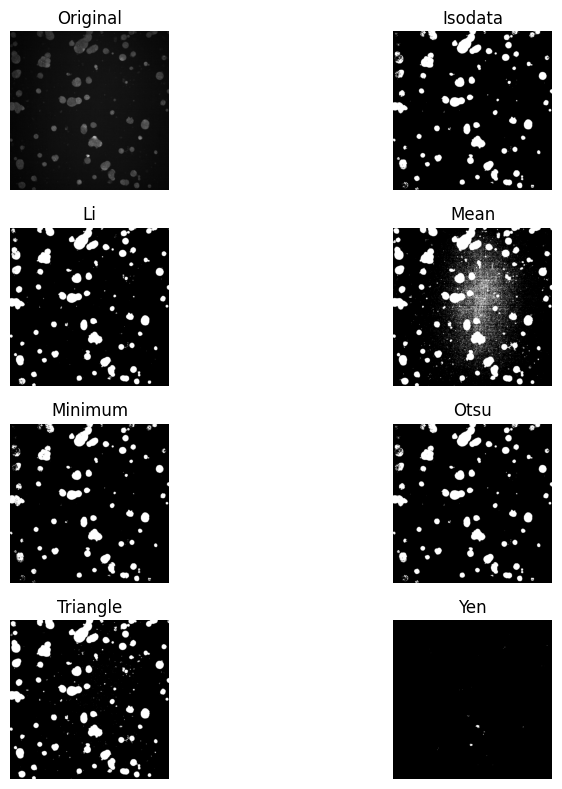

In [5]:
# 2.1: segmentation by thresholding for organoids
# Load the data (size CYX, dtype=float32)
img_example=tifffile.imread(imgs[0])
# We permute the dimensions to YXC
img_example=np.transpose(img_example,(1,2,0))
# We compare different segmentation-by-thresholding methods
fig, ax = try_all_threshold(img_example[:,:,0], figsize=(10, 8), verbose=False)
plt.show()


Analyze the images above in terms of compactness of the segmentations and presence of false alarms (regions that are not organoids but are marked on the images). **Which is the optimal thresholding method in that sense?** Modify the next loop that goes through the sequence of images, performs the segmentation with an threshold you will have to define, applies some postprocessing and saves the images. Visualize the images in the folder `results/segmentation/thresholding/organoids`.

El método de thresholding óptimo es el de Otsu, ya que es uno de los más utilizados (visto en clases anteriores), especialmente cuando los organoides presentan una separación clara de intensidades con respecto al fondo.

In [8]:
for img_file in imgs:
    # Load the data (size CYX, dtype=float32)
    img=tifffile.imread(img_file)
    # We permute the dimensions to YXC
    img=np.transpose(img,(1,2,0))

    # We visually select one of the thresholding methods
    th_org= threshold_otsu(img[:,:,0]) #YOUR_CHOSEN_THRESHOLD_METHOD
    mask_org= img[:,:,0] > th_org  #THRESHOLDING_OPERATION
    # Morphological post processing of the mask: fill holes and filter large regions
    mask_org=binary_fill_holes(mask_org)
    mask_org=filter_regions_by_area(mask_org,300,math.inf) # Organoids have a minimum area of 300 pixels
    # Save the results to visualize them
    image_label_overlay = (255.0*label2rgb(label(mask_org), image=normalize_img(img[:,:,0]), bg_label=0, bg_color=(0,0,0))).astype('uint8')
    imsave(os.path.join(org_segm_th_folder, os.path.basename(img_file[:-4]+'.jpg')), image_label_overlay)
    

#### 2.1.2. Edge-based segmentation

The second strategy for segmentation calculates the edges on the images with the Canny edge detector, links the nearby edges with a closing operation, and applies some morphological post processing over the mask to obtain the final regions corresponding to organoids. First, we try this approach with the example image. 

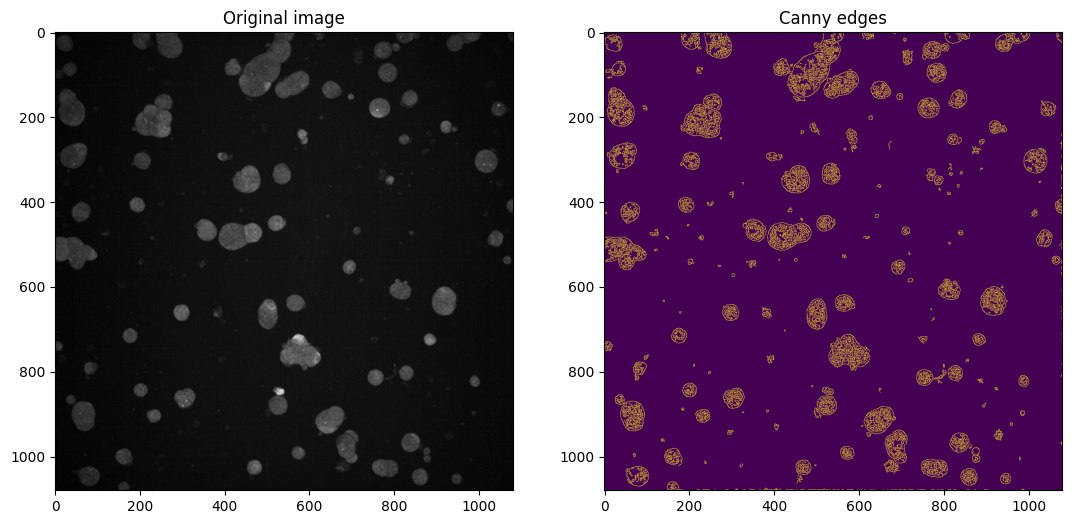

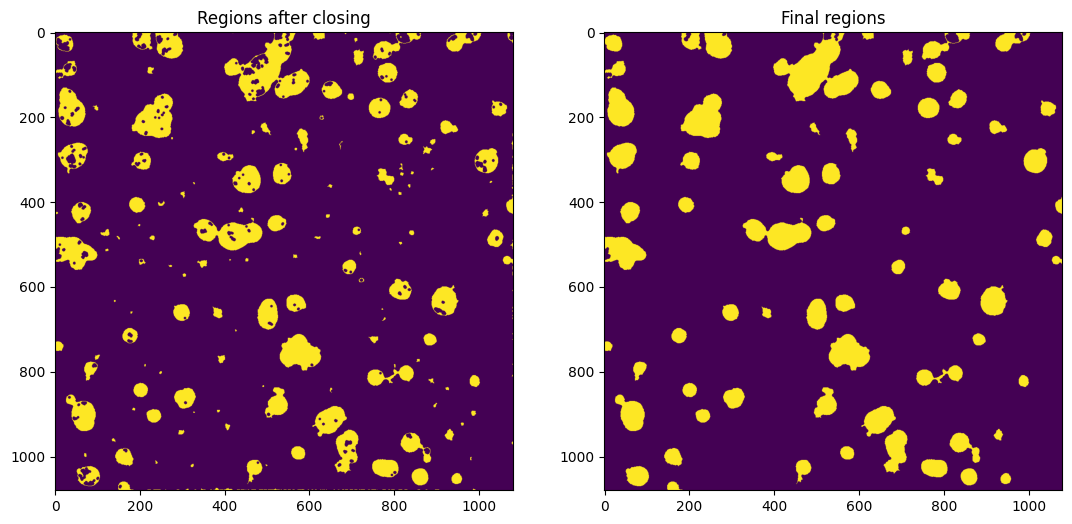

In [9]:
# Segmentation by edge-based methods (edge detection followed by morphology)
# We automatically extract the Canny edges. The Canny edge detector does not detect edges at the border of the image, but there are 
# objects crossing the edge in our images. We use a workaround here, we pad the image with 0s to detect edges at the borders and 
# then we remove the padding
edges = canny(np.pad(normalize_img(img_example[:,:,0]), pad_width=[(1, 1), (1, 1)], mode='constant'),low_threshold=0.05, high_threshold=0.2, sigma=0.1)
edges=edges[1:-1,1:-1]
plt.subplot(1,2,1)
plt.imshow(img_example[:,:,0],cmap='gray')
plt.title('Original image')
plt.subplot(1,2,2)
plt.imshow(edges)
plt.title('Canny edges')
plt.show()
edges=binary_closing(edges,disk(3)) # In this case, we also apply a closing operation to link nearby edges
plt.subplot(1,2,1)
plt.imshow(edges)
plt.title('Regions after closing')
# Morphological post processing of the mask 
mask_org=binary_fill_holes(edges)
mask_org=filter_regions_by_area(mask_org,300,math.inf)
plt.subplot(1,2,2)
plt.imshow(mask_org>0)
plt.title('Final regions')
plt.show()

We apply the same strategy to the complete set of 2D images and save the results in the corresponding folder. 

In [10]:
for img_file in imgs:
    # Load the data (size CYX, dtype=float32)
    img=tifffile.imread(img_file)
    # We permute the dimensions to YXC
    img=np.transpose(img,(1,2,0))
    # We extract the edges on the image
    edges = canny(np.pad(normalize_img(img[:,:,0]), pad_width=[(1, 1), (1, 1)], mode='constant'),low_threshold=0.05, high_threshold=0.2, sigma=0.1)
    edges=edges[1:-1,1:-1]
    # We post process the masks
    mask_org=binary_closing(edges,disk(3))
    mask_org=binary_fill_holes(mask_org)
    mask_org=filter_regions_by_area(mask_org,300,math.inf)
    # We save the results to visualize them
    image_label_overlay = (255.0*label2rgb(mask_org, image=normalize_img(img[:,:,0]), bg_label=0, bg_color=(0,0,0))).astype('uint8')
    imsave(os.path.join(org_segm_eb_folder, os.path.basename(img_file[:-4]+'.jpg')), image_label_overlay)

Now, compare the results in the `results/segmentation/thresholding/organoids` and `results/segmentation/edge_based/organoids` folders. 
**Which method offers the best results? Why do we obtain some holes in the segmentations provided by the edge-based method? Why some adjacent regions are joined in both methods?** We offer a comparison of both methods over the same image in the next cell. 


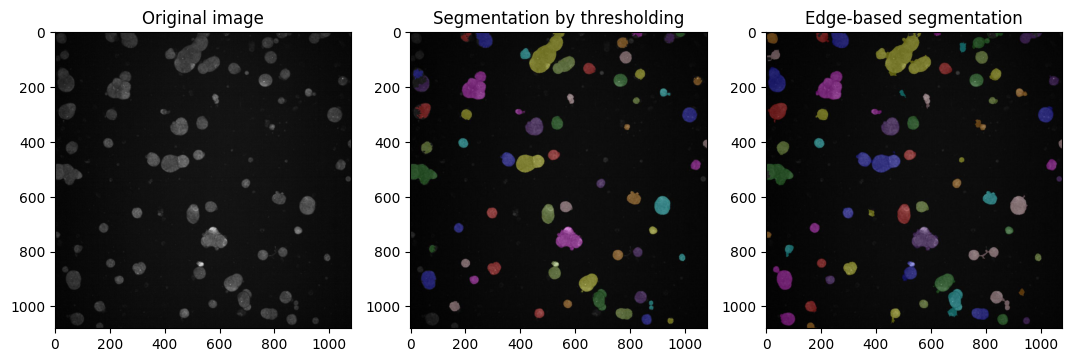

In [11]:
plt.subplot(1,3,1)
plt.imshow(img_example[:,:,0],cmap='gray')
plt.title('Original image')
plt.subplot(1,3,2)
th_image=imread(os.path.join(org_segm_th_folder, os.path.basename(imgs[0][:-4]+'.jpg')))
plt.imshow(th_image)
plt.title('Segmentation by thresholding')
plt.subplot(1,3,3)
eb_image=imread(os.path.join(org_segm_eb_folder, os.path.basename(imgs[0][:-4]+'.jpg')))
plt.title('Edge-based segmentation')
plt.imshow(eb_image)
plt.show()

La segmentación por thresholding es mejor para imágenes con alto contraste objeto-fondo, como ocurre aquí con organoides. El método basado en bordes (Canny + postprocesado morfológico) puede funcionar bien cuando los bordes de los objetos están claramente resaltados, pero es más sensible al ruido y puede fallar si los bordes no son continuos o hay poca separación de intensidad. En este caso concreto, la segmentación por thresholding produce regiones más completas y separadas en los distintos organoides, mientras que edge-based tiende a combinar varios organoides en una instancia por no tener límites claros.

Los huecos en la segmentación basada en bordes ocurre porque el algoritmo de Canny no consigue cerrar los bordes por detectar bordes difusos o interrumpidos. Esto puede ocurrir con organoides que están parcialmente tapados por células T.

En ambos métodos pueden unirse regiones cuando los objetos en la imagen están muy próximos físicamente y el umbral o la detección de bordes no logra separar bien los píxeles entre ellos. En thresholding, esto puede verse en regiones adyacentes con valores similares que se agrupan en la misma clase binaria. En edge-based, el relleno de agujeros puede expandirse a través de pequeñas brechas entre objetos, fusionando varias regiones en una sola.
Este efecto se debe a la resolución espacial, el tamaño de los objetos, la proximidad de los bordes y los parámetros de los filtros morfológicos y de umbralado.

### 2.2. Feature extraction.

The next step on our death dynamics analysis is computing the features for describing the segmented organoids. For that purpose, we will use the `skimage.feature.regionprops` function, which extracts several properties from regions on a labeled image. In our case, we will compute two features:

- Death intensity mean, the mean intensity of the death dye inside the organoid region.
- T-cell intensity mean, the mean intensity of the T-cell dye inside the organoid region (an indirect descriptor of how many T cells are interacting with the organoid without the need of segmenting and identifying the T cells).

Apart from this descriptors, we also save in the DataFrame the name of the image, the identifier of the region and the corners of the bounding box encompassing the organoid, which will be useful to visualize the results. 

Complete the code below with your chosen method for segmentation from the section above, generating the masks.

In [12]:
# We create a pandas DataFrame to store the properties from the different regions
features=pd.DataFrame()
for img_file in imgs:

    # Load the data (size CYX, dtype=float32)
    img=tifffile.imread(img_file)
    # We permute the dimensions to YXC
    img=np.transpose(img,(1,2,0))
    
    # Include here your preferred method for segmentation
    th_org= threshold_otsu(img[:,:,0])
    mask_org= img[:,:,0] > th_org
    # 2.1.2 Morphological post processing of the mask 
    mask_org=binary_fill_holes(mask_org)
    mask_org=filter_regions_by_area(mask_org,300,math.inf)
    # Let's extract some features: we will start with the mean dead intensity and the mean tcell intensity on the organoids
    regs=regionprops(label_image=mask_org, intensity_image=img)
    for reg in regs:
        features=pd.concat((features, pd.DataFrame({'image': [img_file], 'region_id': [reg.label],'bbox0':[reg.bbox[0]],'bbox1':[reg.bbox[1]],'bbox2':[reg.bbox[2]],'bbox3':[reg.bbox[3]],
                   'death_intensity_mean':[reg.intensity_mean[1]], 'tcell_intensity_mean':[reg.intensity_mean[2]]},index=None)),axis=0, ignore_index=True)

We can plot the features to visualize their joint distribution. **Do you find any correlation between them?**

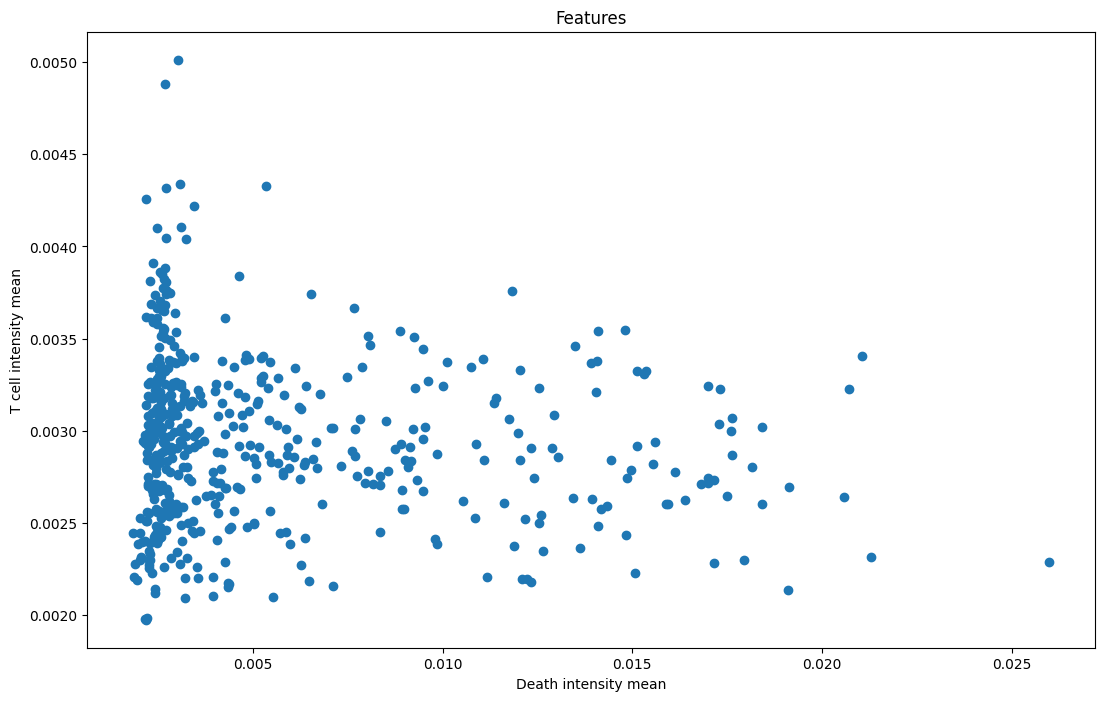

In [13]:
fig=plt.figure()
plt.scatter(features.loc[:,'death_intensity_mean'].values,features.loc[:,'tcell_intensity_mean'].values)
plt.title('Features')
plt.xlabel('Death intensity mean')
plt.ylabel('T cell intensity mean')
plt.show()

No se observa ninguna correlación, ya que para todos los valores de x hay valores en y, no hay ninguna tendencia clara.

### 2.4. Clustering.

The final step on our death dynamics analysis is performing the clustering over the extracted features for discovering the different categories on our organois. This process implies normalizing the features (this step is very important since them can have different ranges, and we don't want the clustering to be biased towards any of them due to this fact), and applying K-Means to separate the data in different categories. Note that in our case we obtain two different categories for the analyzed organoids.

In [14]:
# Clusterize the features to reveal unsupervised categories of organoids
# We transform the features of interest to a numpy array
cluster_features=features.loc[:,['death_intensity_mean','tcell_intensity_mean']].to_numpy() 
# Normalize the features (this is very important, they could have different range). Z-score (mean and standard deviation) is recommended
scaler=StandardScaler()
cluster_features=scaler.fit_transform(cluster_features)
# Apply KMeans to discover the clusters
kmeans=KMeans(n_clusters=N_CLUSTERS,n_init='auto',random_state=SEED).fit(cluster_features)
# Obtain the labels from KMeans, in the range [0,N)
labels=kmeans.predict(cluster_features)
# Save the labels for each region
features['label']=labels

### 2.5. Results.

Once the organoids have been classified, we are going to analyze the results to check if they make sense or not. First, we visualize the features and the clustering results to describe the two organoid categories. 
**What are the differences between the organoid categories? Are they descriptive of the death dynamics of the organoids?**

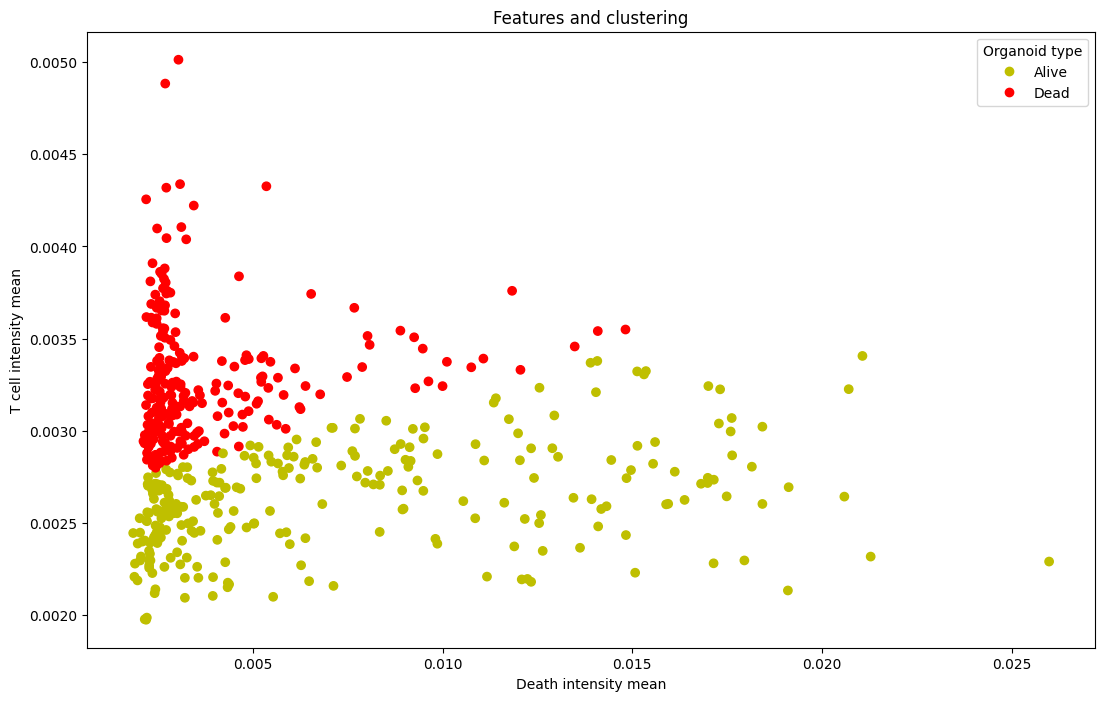

In [15]:
# Visualize the features in 2D with their corresponding clusters
scatter=plt.scatter(features.loc[:,'death_intensity_mean'].values,features.loc[:,'tcell_intensity_mean'].values,c=labels,cmap=ListedColormap(CLUSTER_COLORS))
plt.title('Features and clustering')
plt.xlabel('Death intensity mean')
plt.ylabel('T cell intensity mean')
handles, lbls=scatter.legend_elements()
plt.legend(handles, CLUSTER_LABELS,title="Organoid type")
plt.show()

Los organoides muertos tienen una mayor intensidad media de células T en comparación con los organoides vivos. Esto tiene sentido debido a que son las células T las que atacan y terminan matando a los organoides, por lo que un aumento en intensidad de células T implica mayor ataque y muerte celular.

In our dataset there are images from two different videos belonging to cocultures coming from two different patients. The images that we have analyzed correspond to different timepoints of the videos (initial, middle and final ones). By analyzing the organoid death dynamics we can compare how the two patients respond to therapy. **Who is better responding to therapy, *r06c05f02* or *r06c05f03*?**

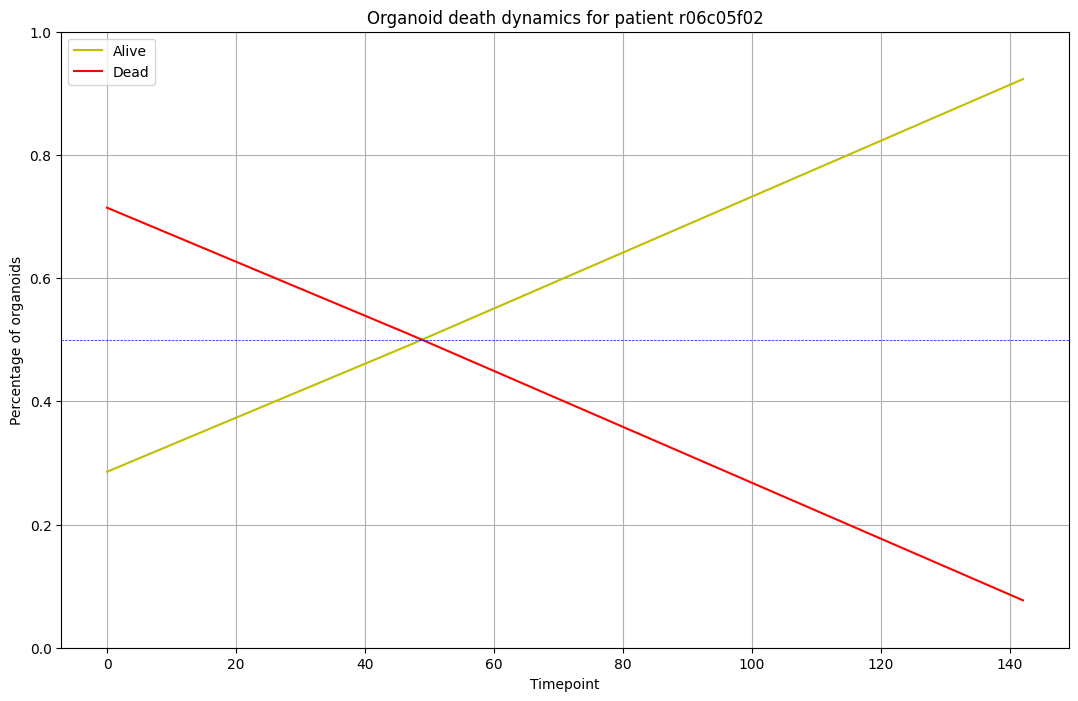

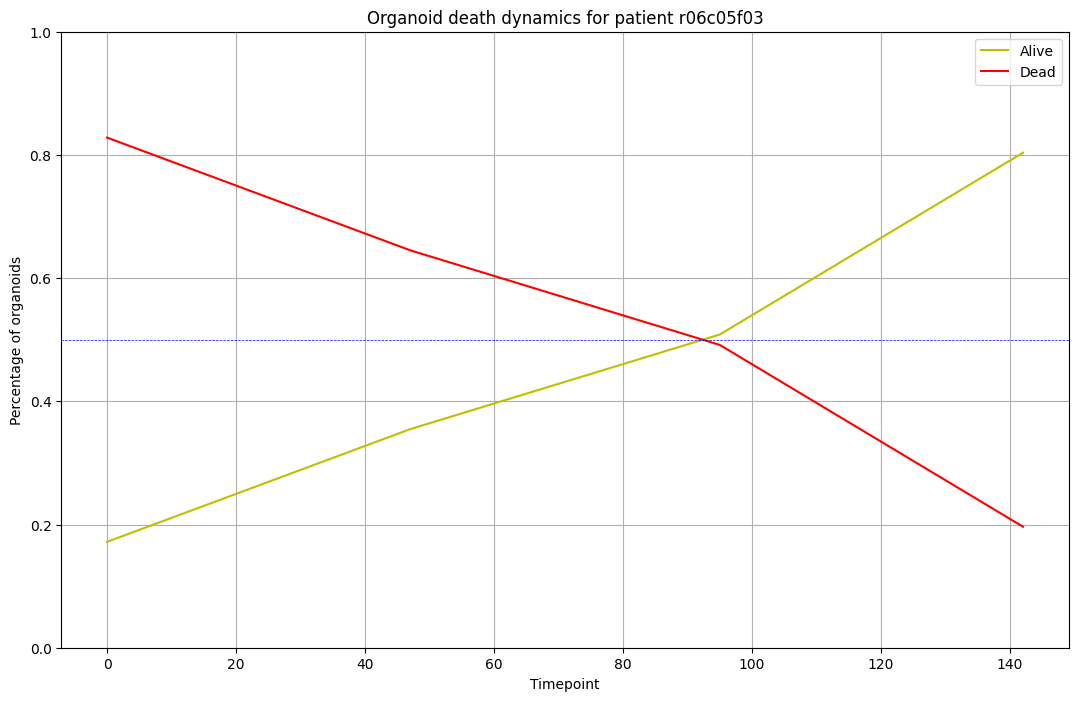

In [16]:
# 5.2 Plot the death dynamics per patient
for p in PATIENTS:
    imgs_patient=natsort.natsorted(glob.glob(os.path.join(folder,p+'*.tif')))
    cluster_dynamics=np.zeros((len(imgs_patient),N_CLUSTERS),dtype='float32')
    timepoints=np.zeros((len(imgs_patient),),dtype='int')
    for i, img_file in enumerate(imgs_patient):
        # Extract the regions of this image
        features_img=features.loc[features['image']==img_file,:]
        for j in range(N_CLUSTERS):
            aux=features_img.loc[:,'label'].values==j
            cluster_dynamics[i,j]=np.sum(aux)/aux.size
        timepoints[i]=int(img_file.split('_t')[2].split('.tif')[0])
    fig=plt.figure()
    for j in range(N_CLUSTERS):
        plt.plot(timepoints,cluster_dynamics[:,j],CLUSTER_COLORS[j])
    plt.title('Organoid death dynamics for patient '+p)
    plt.ylabel('Percentage of organoids')
    plt.xlabel('Timepoint')
    plt.axhline(y=0.5, color='b', linestyle='--',linewidth=0.5)
    plt.ylim([0,1])
    plt.legend(CLUSTER_LABELS)
    plt.grid(True)
    plt.show()

El tratamiento funciona mejor para el primer paciente, ya que las células vivas superan a las muertas en un punto anterior (50 vs 90). 

Finally, we can create a set of images with the results of the clustering superimposed. In this way, we can observe the alive and dead organoids and analyze the errors. Take a look to the images in the folder `results/clustering/organoids` and observe the one shown below. **Do you find some specific errors on the classification? Think about why they are happening. How would you solve these errors?**

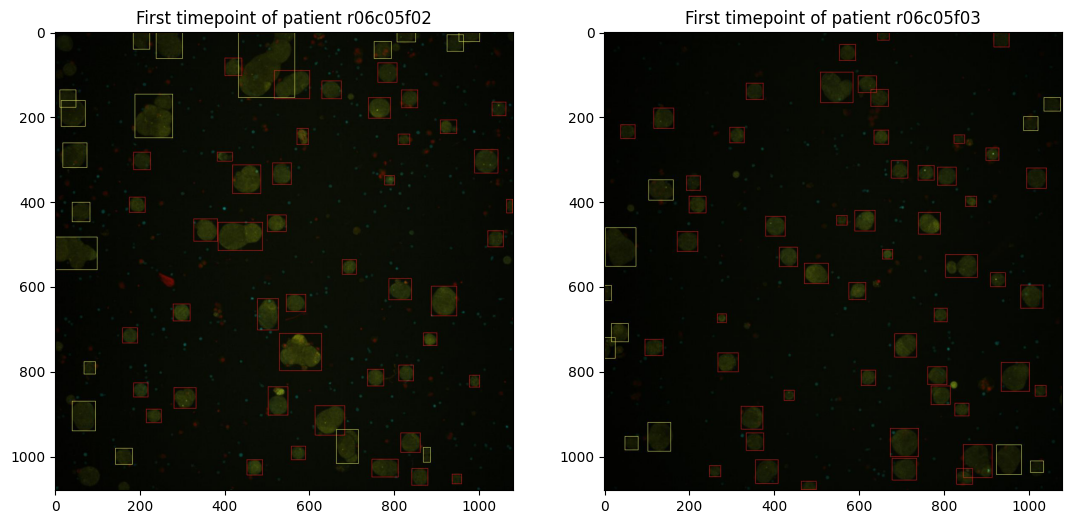

In [17]:
# Visualize the images with the superimposed clustering, draw the bounding boxes over the images with their labels
for img_file in imgs:
    # Load the data (size CYX, dtype=float32)
    img=tifffile.imread(img_file)
    # We permute the dimensions to YXC
    img=np.transpose(img,(1,2,0))
    img=normalize_img(img)
    img=visualize_img(img)
    # Extract the regions of this image
    features_img=features.loc[features['image']==img_file,:]
    for id, feat in features_img.iterrows():
        [rr,cc]=rectangle_perimeter(start=[feat['bbox0'],feat['bbox1']],end=[feat['bbox2']-1,feat['bbox3']-1],shape=img.shape, clip=True)
        if (CLUSTER_COLORS[feat['label']]=='y'):
            # Yellow
            img[rr,cc,0]=1
            img[rr,cc,1]=1
        elif (CLUSTER_COLORS[feat['label']]=='r'):
            # Red
            img[rr,cc,0]=1
        elif (CLUSTER_COLORS[feat['label']]=='m'):
            # Magenta
            img[rr,cc,1]=1
            img[rr,cc,2]=1
    
    imsave(os.path.join(cluster_folder_org, os.path.basename(img_file[:-4]+'.jpg')), (255.0*img).astype('uint8'))

# Show a couple of examples of organoid clustering
cluster_image=imread(os.path.join(cluster_folder_org, os.path.basename(imgs[0][:-4]+'.jpg')))
plt.subplot(1,2,1)
plt.imshow(cluster_image)
plt.title('First timepoint of patient '+PATIENTS[0])

cluster_image=imread(os.path.join(cluster_folder_org, os.path.basename(imgs[4][:-4]+'.jpg')))
plt.subplot(1,2,2)
plt.imshow(cluster_image)
plt.title('First timepoint of patient '+PATIENTS[1])
plt.show()


Algunos organoides no se detectan por el algoritmo, posiblemente por el bajo contraste que tienen en comparación con el fondo. Esto ocurre por ejemplo en la esquina superior izquierda del paciente r06c05f02. Además, varios organoides se pueden detectar como uno solo (paciente r06c05f03, centro derecha). Observando los distintos timepoints, se puede ver cómo de algunos organoides después se detectan dos, estando uno vivo y otro muerto cuando el organoide detectado previamente estaba muerto. 

Estos errores se deben a limitaciones del propio algoritmo de Otsu, el cual no puede separar los organoides tan cercanos, además de variaciones en las señales. Algunas señales rojas son tan débiles que el algoritmo detecta los organoides como vivos, cuando realmente están muertos, u organoides que están marcados como muertos y no tienen ninguna señal roja.

## 6. Further work.

In this section we propose some improvements and additional experiments to perform over the death dynamics analysis shown above.

### 1. Improve the clustering by normalizing the dyes intensity.
Microscopic imaging is subject to uneven illumination and photobleaching, that could affect the precision of our results. However, in our experiments, the three dyes behave similarly, which means that their fluorescency levels are very similar in presence of uneven illumination or photobleaching. We are going to take advantage of this fact:
- Normalize the death and T cell intensities by the organoid dye intensity when extracting the features and perform the same analyses as above. 
**Has the clustering improved? Could you identify where the new clustering outperforms the previous one? Are the two features now useful for clustering?**

In [18]:
# Save the results in a new folder for comparison with the previous ones
cluster_folder_org=os.path.join('results','clustering','organoids_norm_features')
create_folder(cluster_folder_org)
# Include your code here

norm_features = pd.DataFrame()
for img_file in imgs:
    img = tifffile.imread(img_file)
    img = np.transpose(img, (1,2,0))
    
    thresh_val = threshold_otsu(img[:,:,0])
    mask_org = img[:,:,0] > thresh_val
    mask_org = binary_fill_holes(mask_org)
    mask_org = filter_regions_by_area(mask_org, 300, math.inf)
    
    regs = regionprops(label(mask_org), intensity_image=img)
    for reg in regs:
        # Normalization step
        organoid_intensity_mean = reg.intensity_mean[0]
        death_norm = reg.intensity_mean[1] / organoid_intensity_mean if organoid_intensity_mean > 0 else 0
        tcell_norm = reg.intensity_mean[2] / organoid_intensity_mean if organoid_intensity_mean > 0 else 0
        norm_features = pd.concat((norm_features, pd.DataFrame({
            'image': [img_file],
            'region_id': [reg.label],
            'bbox0': [reg.bbox[0]],
            'bbox1': [reg.bbox[1]],
            'bbox2': [reg.bbox[2]],
            'bbox3': [reg.bbox[3]],
            'death_intensity_norm': [death_norm],
            'tcell_intensity_norm': [tcell_norm]
        })), axis=0, ignore_index=True)

        imsave(os.path.join(cluster_folder_org, os.path.basename(img_file[:-4]+'.jpg')), (255.0*img).astype('uint8'))


C:\Users\Sandra\anaconda3\envs\microscopy_training\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: results\clustering\organoids_norm_features\r06c05f02_timeseries_b_t0.jpg is a low contrast image
  return func(*args, **kwargs)
C:\Users\Sandra\anaconda3\envs\microscopy_training\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: results\clustering\organoids_norm_features\r06c05f02_timeseries_b_t0.jpg is a low contrast image
  return func(*args, **kwargs)
C:\Users\Sandra\anaconda3\envs\microscopy_training\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: results\clustering\organoids_norm_features\r06c05f02_timeseries_b_t0.jpg is a low contrast image
  return func(*args, **kwargs)
C:\Users\Sandra\anaconda3\envs\microscopy_training\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: results\clustering\organoids_norm_features\r06c05f02_timeseries_b_t0.jpg is a low contrast image
  return func(*args, **kwargs)
C:\Users\Sandra\anaconda3\envs\microscop

### 2. Analyze the complete organoid death dynamics for the two different patients.

Repeat the process with the images in the folder `images_all`. Segment the organoids, extract the features, **normalize them with the same scaler and apply the same clustering trained in the sections above**. Then, compute the organoid death dynamics curves for each patient and save the images to visualize the clustering results in each frame of the video. 

**Are the curves stable? How would you solve the small instabilities?**
**By observing the images, is the clustering stable in general, e.g., is there a timepoint when an organoid dies and remains as dead in the following timepoints?**

In [ ]:
# Save the results in a new folder for comparison with the previous ones
cluster_folder_org=os.path.join('results','clustering','organoids_all')
create_folder(cluster_folder_org)
# Include your code here

### 3. Include new features in the clustering.

You can include other statistics over the intensities of the channel or other features (shape of organoids, etc.) to improve the clustering.

In [ ]:
# Save the results in a new folder for comparison with the previous ones
cluster_folder_org=os.path.join('results','clustering','organoids_new_features')
create_folder(cluster_folder_org)
# Include your code here

## 7. T cell behavior discovery.

Perform the same process over the T cells: segmentation, feature extraction and clustering. The objective is to classify the T cells into 3 different categories: dead cells, scanner cells (far from an organoid, not interacting with them) and engager cells (cells interacting with organoids). 

**HINTS**: 
- Segmentation: in this case, edge-based segmentation seems to perform better than thresholding due to the uneven illumination of the T-cell channel.
- Feature extraction: you will need to jointly characterize organoids and T cells. The dead channel is useful to distinguish the dead T cells and you will have to compute the distance among T cells and the closest organoid. Use the `scipy.ndimage.distance_transform_edt` function with the organoid mask and, for each T cell, select the minimum distance to an organoid.


In [ ]:
N_CLUSTERS=3
CLUSTER_COLORS=['g','b','r'] 
CLUSTER_LABELS=['engager', 'scanner', 'dead']
# Create the results' folder structure
# Segmentation by thresholding
tcell_segm_th_folder=os.path.join('results','segmentation','thresholding','tcells')
create_folder(tcell_segm_th_folder)
# Edge-based segmentation
tcell_segm_eb_folder=os.path.join('results','segmentation','edge_based','tcells')
create_folder(tcell_segm_eb_folder)
# Clustering results
cluster_folder_tcell=os.path.join('results','clustering','tcells')
create_folder(cluster_folder_tcell)
